# Deep Convolutional Generative Adversarial Network

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
from IPython.core.pylabtools import figsize

import os, sys, time
import json
import numpy as np
import pandas as pd
import numpy.random as nr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

import torchvision as tv
import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


In [2]:
def plot_samples(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)
    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return fig

def show_images(rows, cols, real, fake):
    n = rows * cols
    fake_images = fake.reshape(-1, 28, 28)[:n//2]
    real_images = real.reshape(-1, 28, 28)[:n//2]
    for i, (img_f, img_r) in enumerate(zip(fake_images, real_images)):
        plt.subplt(rows, cols, 2*i+1)
        plt.imshow(img_r, cmap=plt.cm.gray)
        plt.axis('off')    
        plt.subplt(rows, cols, 2*i+2)
        plt.imshow(img_f, cmap=plt.cm.gray)
        plt.axis('off')    


In [3]:
latent_dim = 100
batch_size = 100
image_size = 28
image_chan = 1

In [4]:
train_ds = tv.datasets.MNIST('/data/datasets/MNIST/', train=True, 
                             transform=tv.transforms.ToTensor())
valid_ds = tv.datasets.MNIST('/data/datasets/MNIST/', train=False, 
                             transform=tv.transforms.ToTensor())
n_train = len(train_ds)
n_valid = len(valid_ds)
print('Número de amostras no dataset (treino):', n_train)
print('Número de amostras no dataset (teste ):', n_valid)

train_dloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,   pin_memory=True)
valid_dloader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False,  pin_memory=True)

Número de amostras no dataset (treino): 60000
Número de amostras no dataset (teste ): 10000


In [5]:
# https://github.com/pytorch/examples/blob/master/dcgan/main.py
# ---------------------------
# Imagens nc x 64 x 64
# ---------------------------

class GNet64(nn.Module):
    def __init__(self, nz=latent_dim, nc=image_chan, ngf=64):
        super().__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output


class DNet64(nn.Module):
    def __init__(self, ndf=64, nc=image_chan):
        super().__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


In [6]:
# ---------------------------
# Imagens nc x 28 x 28
# ---------------------------

class GNet(nn.Module):
    def __init__(self, nz=latent_dim, nc=image_chan, ngf=64):
        super().__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        output = self.main(input)
        return output


class DNet(nn.Module):
    def __init__(self, ndf=64, nc=image_chan):
        super().__init__()
        self.main = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


In [7]:
d_net = DNet()
g_net = GNet()

In [8]:
niter = 100
save_interval = 20
print_interval = 10

opt_lr = 0.0002
opt_beta1 = 0.5

d_input = torch.FloatTensor(batch_size, image_chan, image_size, image_size)
noise = torch.FloatTensor(batch_size, latent_dim, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)

real_label = 1
fake_label = 0

if use_gpu:
    d_net.cuda()
    g_net.cuda()
    d_input, label = d_input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

fixed_noise = Variable(fixed_noise)

# setup optimizer
D_optimizer = Adam(d_net.parameters(), lr=opt_lr, betas=(opt_beta1, 0.999))
G_optimizer = Adam(g_net.parameters(), lr=opt_lr, betas=(opt_beta1, 0.999))

criterion = nn.BCELoss()

try:
    for epoch in range(niter+1):
        t0 = time.time()
        for i, (x_real, _) in enumerate(train_dloader):
            curr_batch_size = x_real.size(0)
            # -----------------------------------------------------------
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            # -----------------------------------------------------------
            d_net.zero_grad()

            # train with real        
            if use_gpu:
                x_real = x_real.cuda()
            d_input.resize_as_(x_real).copy_(x_real)
            label.resize_(batch_size).fill_(real_label)
            inputv = Variable(d_input)
            labelv = Variable(label)

            output = d_net(inputv)
            d_error_real = criterion(output, labelv)
            d_error_real.backward()
            d_x = output.data.mean()

            # train with fake
            noise.resize_(batch_size, latent_dim, 1, 1).normal_(0, 1)
            noisev = Variable(noise)
            labelv = Variable(label.fill_(fake_label))

            fake_data = g_net(noisev)
            output = d_net(fake_data.detach())
            d_error_fake = criterion(output, labelv)
            d_error_fake.backward()
            d_g_z1 = output.data.mean()

            d_error = d_error_real + d_error_fake
            D_optimizer.step()

            # -------------------------------------------
            # (2) Update G network: maximize log(D(G(z)))
            # -------------------------------------------
            g_net.zero_grad()

            # fake labels are real for generator cost
            labelv = Variable(label.fill_(real_label))

            output = d_net(fake_data)
            g_error = criterion(output, labelv)
            g_error.backward()

            d_g_z2 = output.data.mean()
            G_optimizer.step()

        if epoch % print_interval == 0:
            print('{:2d}.{:3d}: {:.4f} {:.4f}  [{:.2f}s]'.format(epoch, i, d_error.data[0], 
                                                                 g_error.data[0], time.time() - t0))

        if epoch % save_interval == 0:
            noise.resize_(16, latent_dim, 1, 1).normal_(0, 1)
            noisev = Variable(noise)
            fake_data = g_net(noisev)

            fig = plot_samples(fake_data.data.cpu().numpy())
            plt.savefig('images/dcgan_img_{:04d}.png'.format(epoch, bbox_inches='tight'))
            plt.close(fig)

except KeyboardInterrupt:
    print('Interrupted!')
    

 0.599: 0.3071 2.2206  [44.42s]
10.599: 0.7790 1.6228  [44.38s]
20.599: 0.7973 1.7915  [44.30s]
30.599: 0.4627 2.4701  [44.29s]
40.599: 0.7666 1.5941  [44.27s]
50.599: 0.6349 2.2225  [44.29s]
60.599: 0.3884 2.7871  [44.31s]
70.599: 0.3879 4.2932  [44.26s]
80.599: 0.3571 4.7278  [44.25s]
90.599: 0.5318 4.4347  [44.27s]
100.599: 0.3671 3.4003  [44.25s]


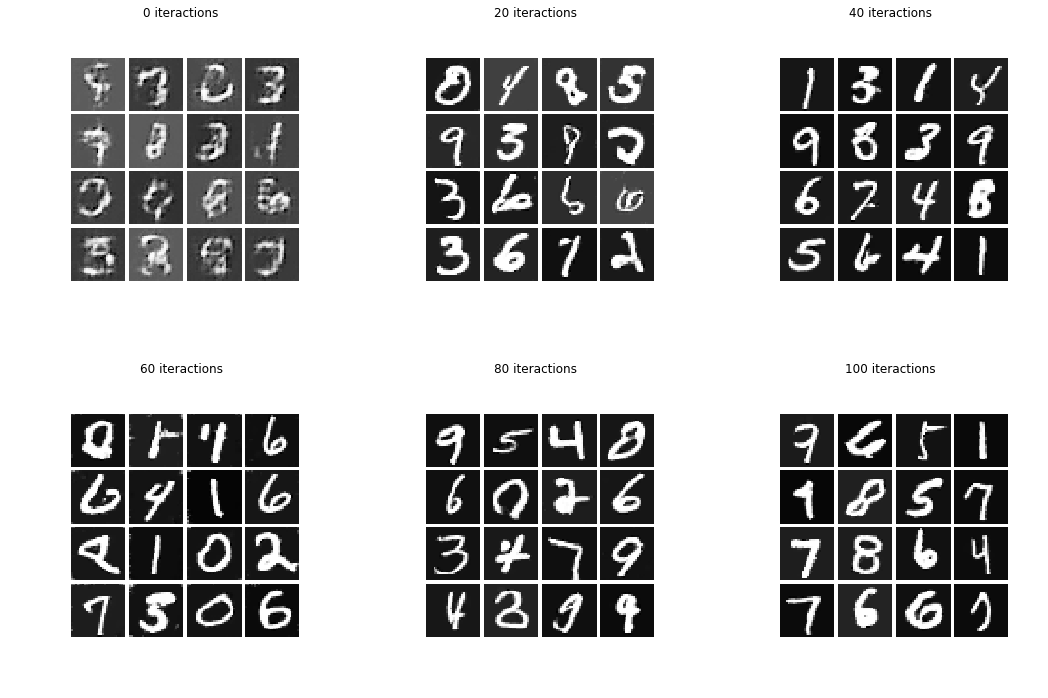

In [15]:
fig = plt.figure(figsize=(18, 12))

shape = (100, 100)
for i, fn in enumerate([0, 20, 40, 60, 80, 100]):
    fig.add_subplot(2, 3, i+1)
    image_fn = 'images/dcgan_img_{:04d}.png'.format(fn)
    img = plt.imread(image_fn)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('{} iteractions'.format(fn))
 